# Baseline

##### Imports

In [200]:
# Importing Required Modules
import gym
import numpy as np
import or_gym
import pandas as pd


import matplotlib.pyplot as plt

from tqdm import tqdm

# Importing PPO Algorithm and Base Policy
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy

from sb3_contrib import TRPO
from sb3_contrib.trpo.policies import MlpPolicy as TRPOPolicy

from sb3_contrib import ARS
from sb3_contrib.ars.policies import ARSPolicy

from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import ProgressBarCallback
from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.monitor import Monitor
import torch as th
import os



%load_ext tensorboard
import tensorflow as tf
import datetime 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Experiment 1: Figuring out the environment

Lets create a bunch of actions/ a policy which can interact with the environment. We'll evaluate this very basic policy that I came up with and  see how it does. 

In [197]:

def generate_policy():
    
    actions = []
    # 30 Timesteps
    # Review every 3 steps 
    
    for i in range(30):
        
        if i == 1:
            actions.append([50,50,50])
        
        actions.append([25,25,25])
        
        
        # if i % 10 == 0:
        #     actions.append([20,20,20])
        # else:
        #     actions.append([0,0,0])
    
    return np.array(actions)

actions = generate_policy()

print(actions[3])

[25 25 25]


The actions are in the right shape. Lets set up an environment and try them out.

In [198]:
env = or_gym.make('InvManagement-v1')
env.I0 = np.array([20,20,20])
env.I[0] = env.I0
filepath = 'baserun/'

print(env.I0)


episodes = 1
periods = 30


raw_rewards = np.zeros((episodes, periods))

        
df_names = ['D', 'I', 'R', 'P', 'T'] # Initialising DataFrame names
# ['Market Demand', 'Inventory Node Stock', 'Reorder Amount', 'Node Profit', 'Edge Quantities'] Translated from above

for episode in range(episodes):
    for timestep in range(periods):
        action = actions[timestep]
        obs, reward, _, _ = env.step(action)
        print(env.I0)
        raw_rewards[episode,timestep] = reward
                
        for df_name in df_names:
            df = getattr(env, df_name) # Get the DataFrame from the environment for the specific data
                
            if not os.path.exists(filepath + f'/{episode}/'): # If the directory does not exist, create it
                os.makedirs(filepath + f'/{episode}/')
                
            pd.DataFrame(df).to_csv(filepath + f'/{episode}/{df_name}.csv') # Save the DataFrame as a csv file
                
    # env = env.reset() # Reset the environment for the next episode
    # env.seed_int = int(episode) # Select a new seed for the next episode
            

[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]
[20 20 20]


/var/folders/cl/l2qg34px6s96_4z813158xdh0000gn/T/ipykernel_23461/570967647.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


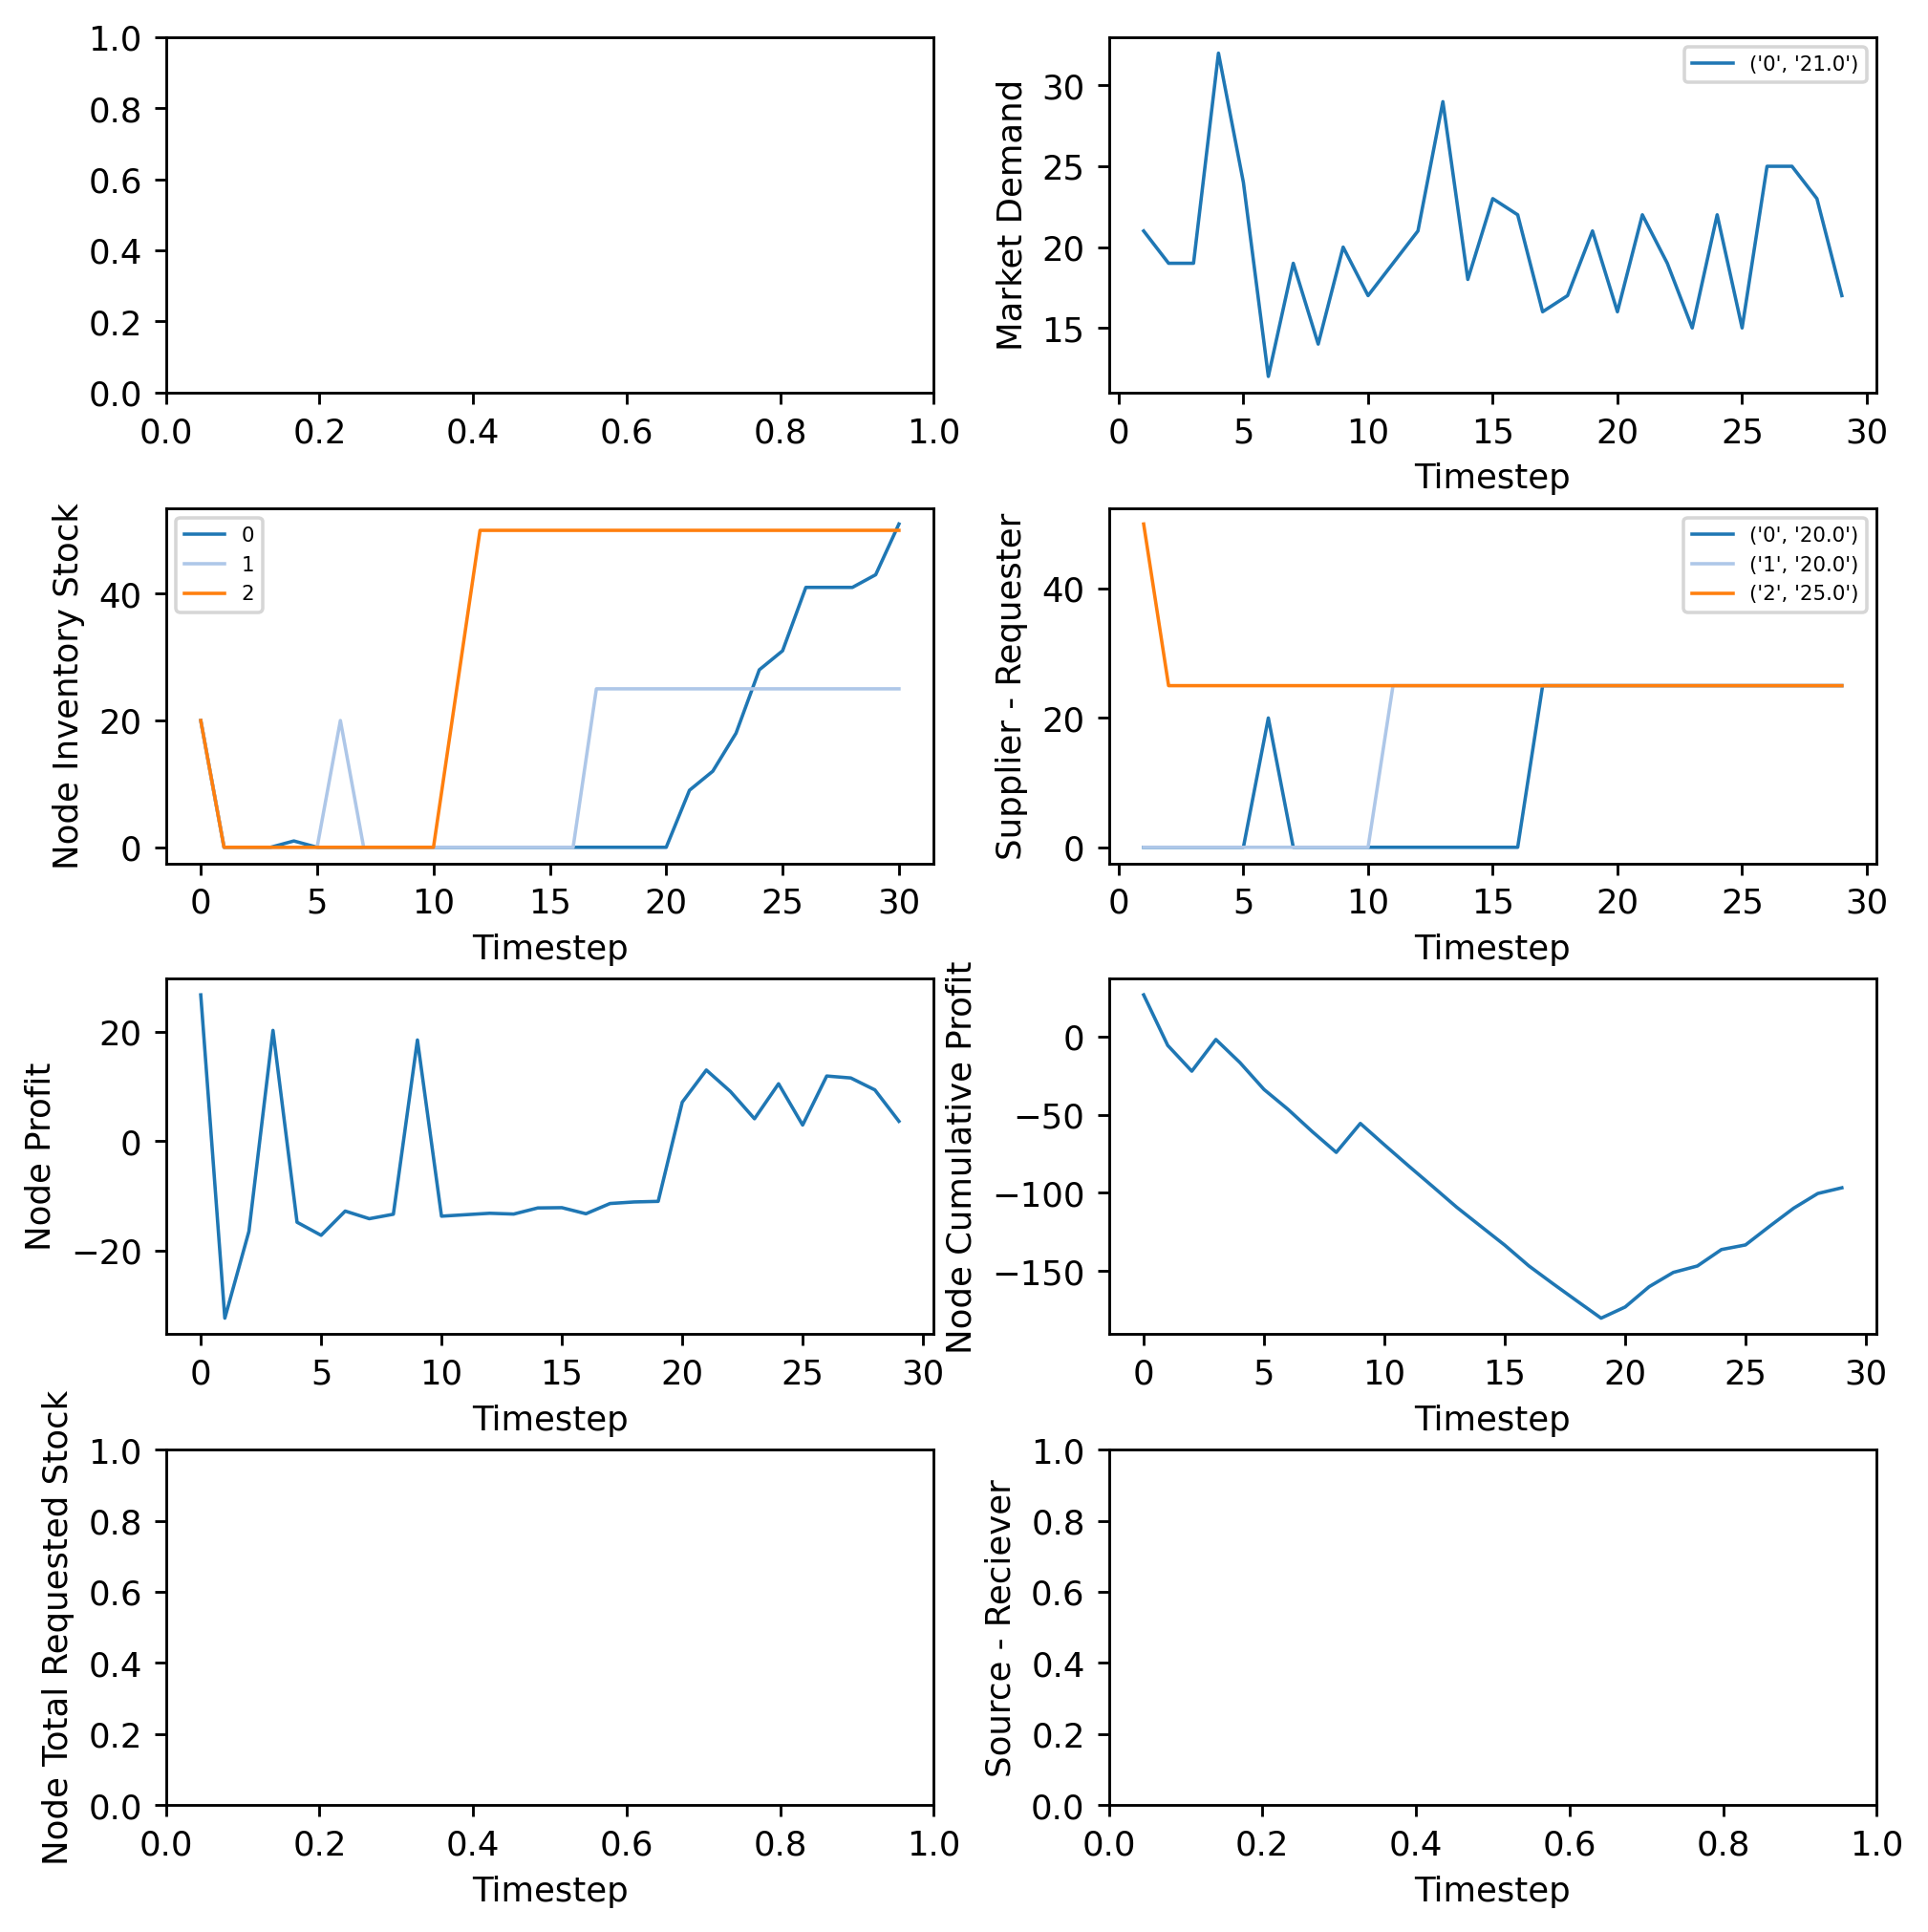

In [199]:
fig, ax = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(8, 8)


df_names = ['D', 'I', 'R', 'P', 'T']
df_headers = [[0,1], [0], [0,1], [0], [0,1]]
data = {}

for i, df_name in enumerate(df_names):
    df = pd.read_csv(filepath + f'/{episode}/{df_name}.csv', index_col=[0], header=df_headers[i])
    data[df_name] = df

cmap = plt.get_cmap('tab20')


for i, retailer_market in enumerate(data['D'].columns):
    retailer, market = retailer_market
    ax[0,1].plot(data['D'][retailer_market], linewidth=1.0, label=retailer_market)

for i, node_num in enumerate(data['I'].columns):
    ax[1,0].plot(data['I'][node_num], linewidth=1.0, label=node_num, color=cmap(i))

for i, supplier_requester in enumerate(data['R'].columns):
    supplier, requester = supplier_requester
    ax[1,1].plot(data['R'][supplier_requester], linewidth=1.0, label=supplier_requester, color=cmap(i))

for i, node_num in enumerate(data['P'].columns):
    ax[2,0].plot(data['P'][node_num], linewidth=1.0, label=node_num, color=cmap(i))
    ax[2,1].plot(np.cumsum(data['P'][node_num]), linewidth=1.0, label=node_num, color=cmap(i))

# Rtot = data['R'].groupby('Requester', axis=1).sum()

# for i, node_num in enumerate(Rtot.columns):
#     ax[3,0].plot(Rtot[node_num], linewidth=1.0, label=node_num, color=cmap(i))

# for i, source_reciever in enumerate(data['T'].columns):
#     source, reciever = source_reciever
#     ax[3,1].plot(data['T'][source_reciever], linewidth=1.0, label=source_reciever, color=cmap(i))

ax[0,1].legend(fontsize=6)
ax[1,0].legend(fontsize=6)
ax[1,1].legend(fontsize=6)

ax[0,1].set_xlabel('Timestep')
ax[0,1].set_ylabel('Market Demand')

ax[1,0].set_xlabel('Timestep')
ax[1,0].set_ylabel('Node Inventory Stock')

ax[1,1].set_xlabel('Timestep')
ax[1,1].set_ylabel('Supplier - Requester')

ax[2,0].set_xlabel('Timestep')
ax[2,0].set_ylabel('Node Profit')

ax[2,1].set_xlabel('Timestep')
ax[2,1].set_ylabel('Node Cumulative Profit')

ax[3,0].set_xlabel('Timestep')
ax[3,0].set_ylabel('Node Total Requested Stock')

ax[3,1].set_xlabel('Timestep')
ax[3,1].set_ylabel('Source - Reciever')


fig.tight_layout(h_pad=0.0, w_pad=0.0)

#     save_dir = f'./figures/{env_name}/'

save_dir = filepath

#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

fig.savefig(save_dir + 'episode.pdf')
fig.show()

Unexpectadely. It is terrible.

In [186]:
env = or_gym.make('InvManagement-v1')
env.I0 = np.array([100,80,80])

env.I0 = np.array([0,0,0])

env.I[0] = env.I0
env.state[0:3] = env.I0
env.dist_param['mu']=0

def get_status():
    print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')
    print("Period Number:", env.period)
    print("Retailer Pipeline \n" , env.state[0::3])
    print("Distributor Pipeline \n" , env.state[1::3])
    print("Manufacturer Pipeline \n" , env.state[2::3])
    print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')


###### Example of Pipeline of orders that aren't satisfied.

In [177]:
env = or_gym.make('InvManagement-v1')
env.I0 = np.array([100,80,80])

env.I0 = np.array([0,0,0])

env.I[0] = env.I0
env.state[0:3] = env.I0
env.dist_param['mu']=0

get_status()
env.step([100,0,0])
get_status()
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])
env.step([100,0,0])

get_status()

Period Number: 0
Retailer Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Distributor Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Manufacturer Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Period Number: 1
Retailer Pipeline 
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]
Distributor Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Manufacturer Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Period Number: 15
Retailer Pipeline 
 [  0. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Distributor Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Manufacturer Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


###### We see the capacity being hit here for the manufacturer.

In [183]:
env = or_gym.make('InvManagement-v1')
env.I0 = np.array([100,80,80])

env.I0 = np.array([0,0,0])

env.I[0] = env.I0
env.state[0:3] = env.I0
env.dist_param['mu']=0

get_status()
env.step([100,100,100])
get_status()
env.step([100,100,100])
env.step([100,100,100])
env.step([100,100,100])
env.step([100,100,100])
env.step([100,100,100])
env.step([100,100,100])
env.step([100,100,100])
env.step([100,100,100])
env.step([100,100,100])
env.step([100,100,100])
env.step([0,0,0])



get_status()

Period Number: 0
Retailer Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Distributor Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Manufacturer Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Period Number: 1
Retailer Pipeline 
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]
Distributor Pipeline 
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]
Manufacturer Pipeline 
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]
Period Number: 12
Retailer Pipeline 
 [  0. 100. 100. 100. 100. 100. 100. 100. 100. 100.   0.]
Distributor Pipeline 
 [  0. 100. 100. 100. 100. 100. 100. 100. 100. 100.   0.]
Manufacturer Pipeline 
 [160. 100. 100. 100. 100. 100. 100. 100. 100. 100.   0.]


###### Lets now see the lead times in action.

In [190]:
env = or_gym.make('InvManagement-v1')
env.I0 = np.array([0,100,100])

env.I[0] = env.I0
env.state[0:3] = env.I0
env.dist_param['mu']=0

get_status()
env.step([40,20,0])
get_status()
env.step([0,0,0])
env.step([0,0,0])
env.step([0,0,0])
get_status()

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Period Number: 0
Retailer Pipeline 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Distributor Pipeline 
 [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Manufacturer Pipeline 
 [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Period Number: 1
Retailer Pipeline 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 40.]
Distributor Pipeline 
 [60.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20.]
Manufacturer Pipeline 
 [80.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Period Number: 4
Retailer Pipeline 
 [40.  0.  0.  0.  0.  0.  0. 40.  0.  0.  0.]
Distributor Pipeline 
 [60.  0.  0.  0.  0.  0.  0. 20.  0.  0.  0.]
Manufacturer Pipeline 
 [80.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


#### Continuous Review and Reorder Point


In this first inventory policy, we order our products based on a fixed threshold: as soon as the net inventory reaches the threshold (or goes below), we order a pre-determined number of units from our supplier (or launch a production batch). This threshold is called the reorder point or ROP

- Create Environment
- Set up decent inventory values
- Run a for loop
    - Grab the current state and all the inventories
    - See if they're above or below the threshold inventory values
    - Order the remainder stock if needed.

In [243]:
periods = 365

env = or_gym.make('InvManagement-v1', periods=periods)
env.I0 = np.array([100,100,200])
env.I[0] = env.I0
env.state[0:3] = env.I0
filepath = 'conrenrepo/'

episodes = 1
raw_rewards = np.zeros((episodes, periods))
  
df_names = ['D', 'I', 'R', 'P', 'T'] # Initialising DataFrame names
# ['Market Demand', 'Inventory Node Stock', 'Reorder Amount', 'Node Profit', 'Edge Quantities'] Translated from above

for episode in range(episodes):
    for timestep in range(periods):
        #Check retailer
        actions = np.zeros(3)
        
        
        R_threshold = 100
        D_threshold = 300
        M_threshold = 400
        
        
        if env.period == 0:
            actions = np.array([100,100,100])
        
        if env.period % 4 == 0:
            if env.state[0] < R_threshold:
                actions[0] = R_threshold - env.state[0]
        
        if env.period % 8 == 0:
            if env.state[1] < D_threshold:
                actions[1] = D_threshold - env.state[1]
          
        if env.period % 11 == 0:        
                if env.state[2] < M_threshold:
                    actions[2] = M_threshold - env.state[2]
        
        obs, reward, _, _ = env.step(actions)
        raw_rewards[episode,timestep] = reward
        
        for df_name in df_names:
            df = getattr(env, df_name) # Get the DataFrame from the environment for the specific data
             
            if not os.path.exists(filepath + f'/{episode}/'): # If the directory does not exist, create it
                os.makedirs(filepath + f'/{episode}/')
                
            pd.DataFrame(df).to_csv(filepath + f'/{episode}/{df_name}.csv') # Save the DataFrame as a csv file
        
        
    #     action = actions[timestep]
    #     obs, reward, _, _ = env.step(action)
    #     print(env.I0)
    #     raw_rewards[episode,timestep] = reward
                
    #     for df_name in df_names:
    #         df = getattr(env, df_name) # Get the DataFrame from the environment for the specific data
                
    #         if not os.path.exists(filepath + f'/{episode}/'): # If the directory does not exist, create it
    #             os.makedirs(filepath + f'/{episode}/')
                
    #         pd.DataFrame(df).to_csv(filepath + f'/{episode}/{df_name}.csv') # Save the DataFrame as a csv file
                
    # # env = env.reset() # Reset the environment for the next episode
    # # env.seed_int = int(episode) # Select a new seed for the next episode
            

/var/folders/cl/l2qg34px6s96_4z813158xdh0000gn/T/ipykernel_23461/1707147628.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


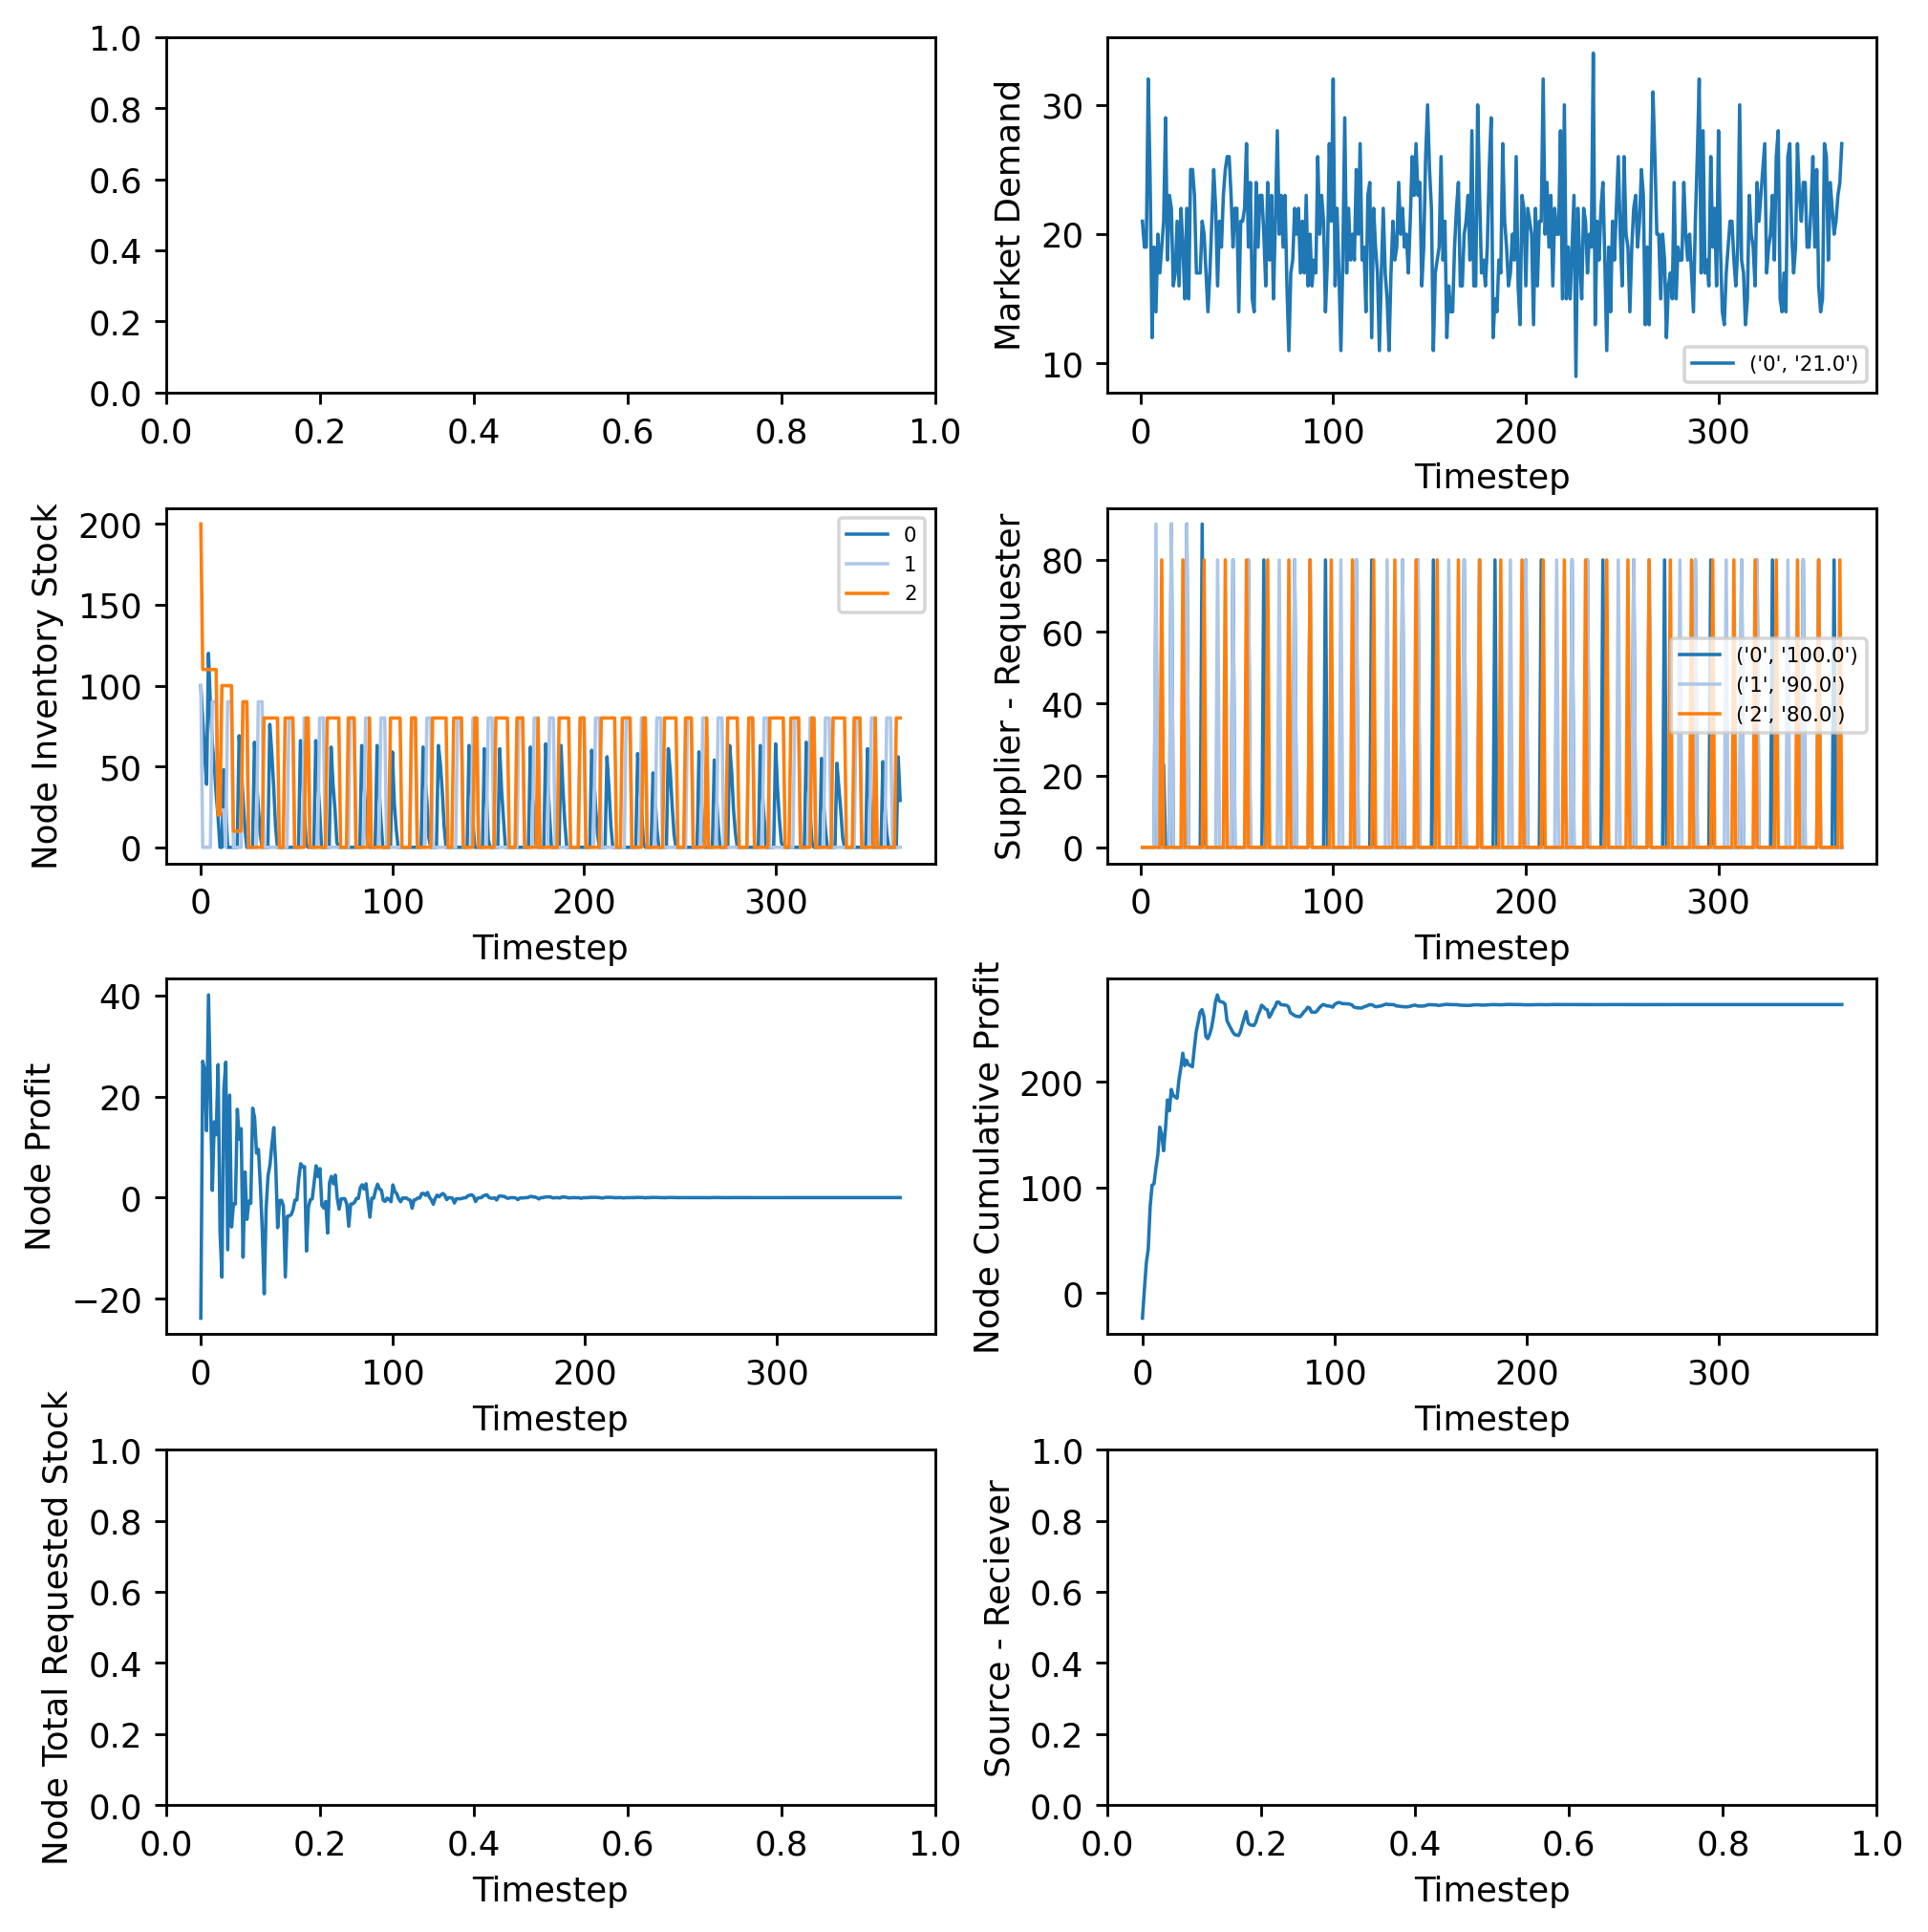

In [244]:


fig, ax = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(8, 8)


df_names = ['D', 'I', 'R', 'P', 'T']
df_headers = [[0,1], [0], [0,1], [0], [0,1]]
data = {}

for i, df_name in enumerate(df_names):
    df = pd.read_csv(filepath + f'/{episode}/{df_name}.csv', index_col=[0], header=df_headers[i])
    data[df_name] = df

cmap = plt.get_cmap('tab20')


for i, retailer_market in enumerate(data['D'].columns):
    retailer, market = retailer_market
    ax[0,1].plot(data['D'][retailer_market], linewidth=1.0, label=retailer_market)

for i, node_num in enumerate(data['I'].columns):
    ax[1,0].plot(data['I'][node_num], linewidth=1.0, label=node_num, color=cmap(i))

for i, supplier_requester in enumerate(data['R'].columns):
    supplier, requester = supplier_requester
    ax[1,1].plot(data['R'][supplier_requester], linewidth=1.0, label=supplier_requester, color=cmap(i))

for i, node_num in enumerate(data['P'].columns):
    ax[2,0].plot(data['P'][node_num], linewidth=1.0, label=node_num, color=cmap(i))
    ax[2,1].plot(np.cumsum(data['P'][node_num]), linewidth=1.0, label=node_num, color=cmap(i))

# Rtot = data['R'].groupby('Requester', axis=1).sum()

# for i, node_num in enumerate(Rtot.columns):
#     ax[3,0].plot(Rtot[node_num], linewidth=1.0, label=node_num, color=cmap(i))

# for i, source_reciever in enumerate(data['T'].columns):
#     source, reciever = source_reciever
#     ax[3,1].plot(data['T'][source_reciever], linewidth=1.0, label=source_reciever, color=cmap(i))

ax[0,1].legend(fontsize=6)
ax[1,0].legend(fontsize=6)
ax[1,1].legend(fontsize=6)

ax[0,1].set_xlabel('Timestep')
ax[0,1].set_ylabel('Market Demand')

ax[1,0].set_xlabel('Timestep')
ax[1,0].set_ylabel('Node Inventory Stock')

ax[1,1].set_xlabel('Timestep')
ax[1,1].set_ylabel('Supplier - Requester')

ax[2,0].set_xlabel('Timestep')
ax[2,0].set_ylabel('Node Profit')

ax[2,1].set_xlabel('Timestep')
ax[2,1].set_ylabel('Node Cumulative Profit')

ax[3,0].set_xlabel('Timestep')
ax[3,0].set_ylabel('Node Total Requested Stock')

ax[3,1].set_xlabel('Timestep')
ax[3,1].set_ylabel('Source - Reciever')


fig.tight_layout(h_pad=0.0, w_pad=0.0)

#     save_dir = f'./figures/{env_name}/'

save_dir = filepath

#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

fig.savefig(save_dir + 'episode.pdf')
fig.show()

#### Changing Capacities

/var/folders/cl/l2qg34px6s96_4z813158xdh0000gn/T/ipykernel_23461/2390747564.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


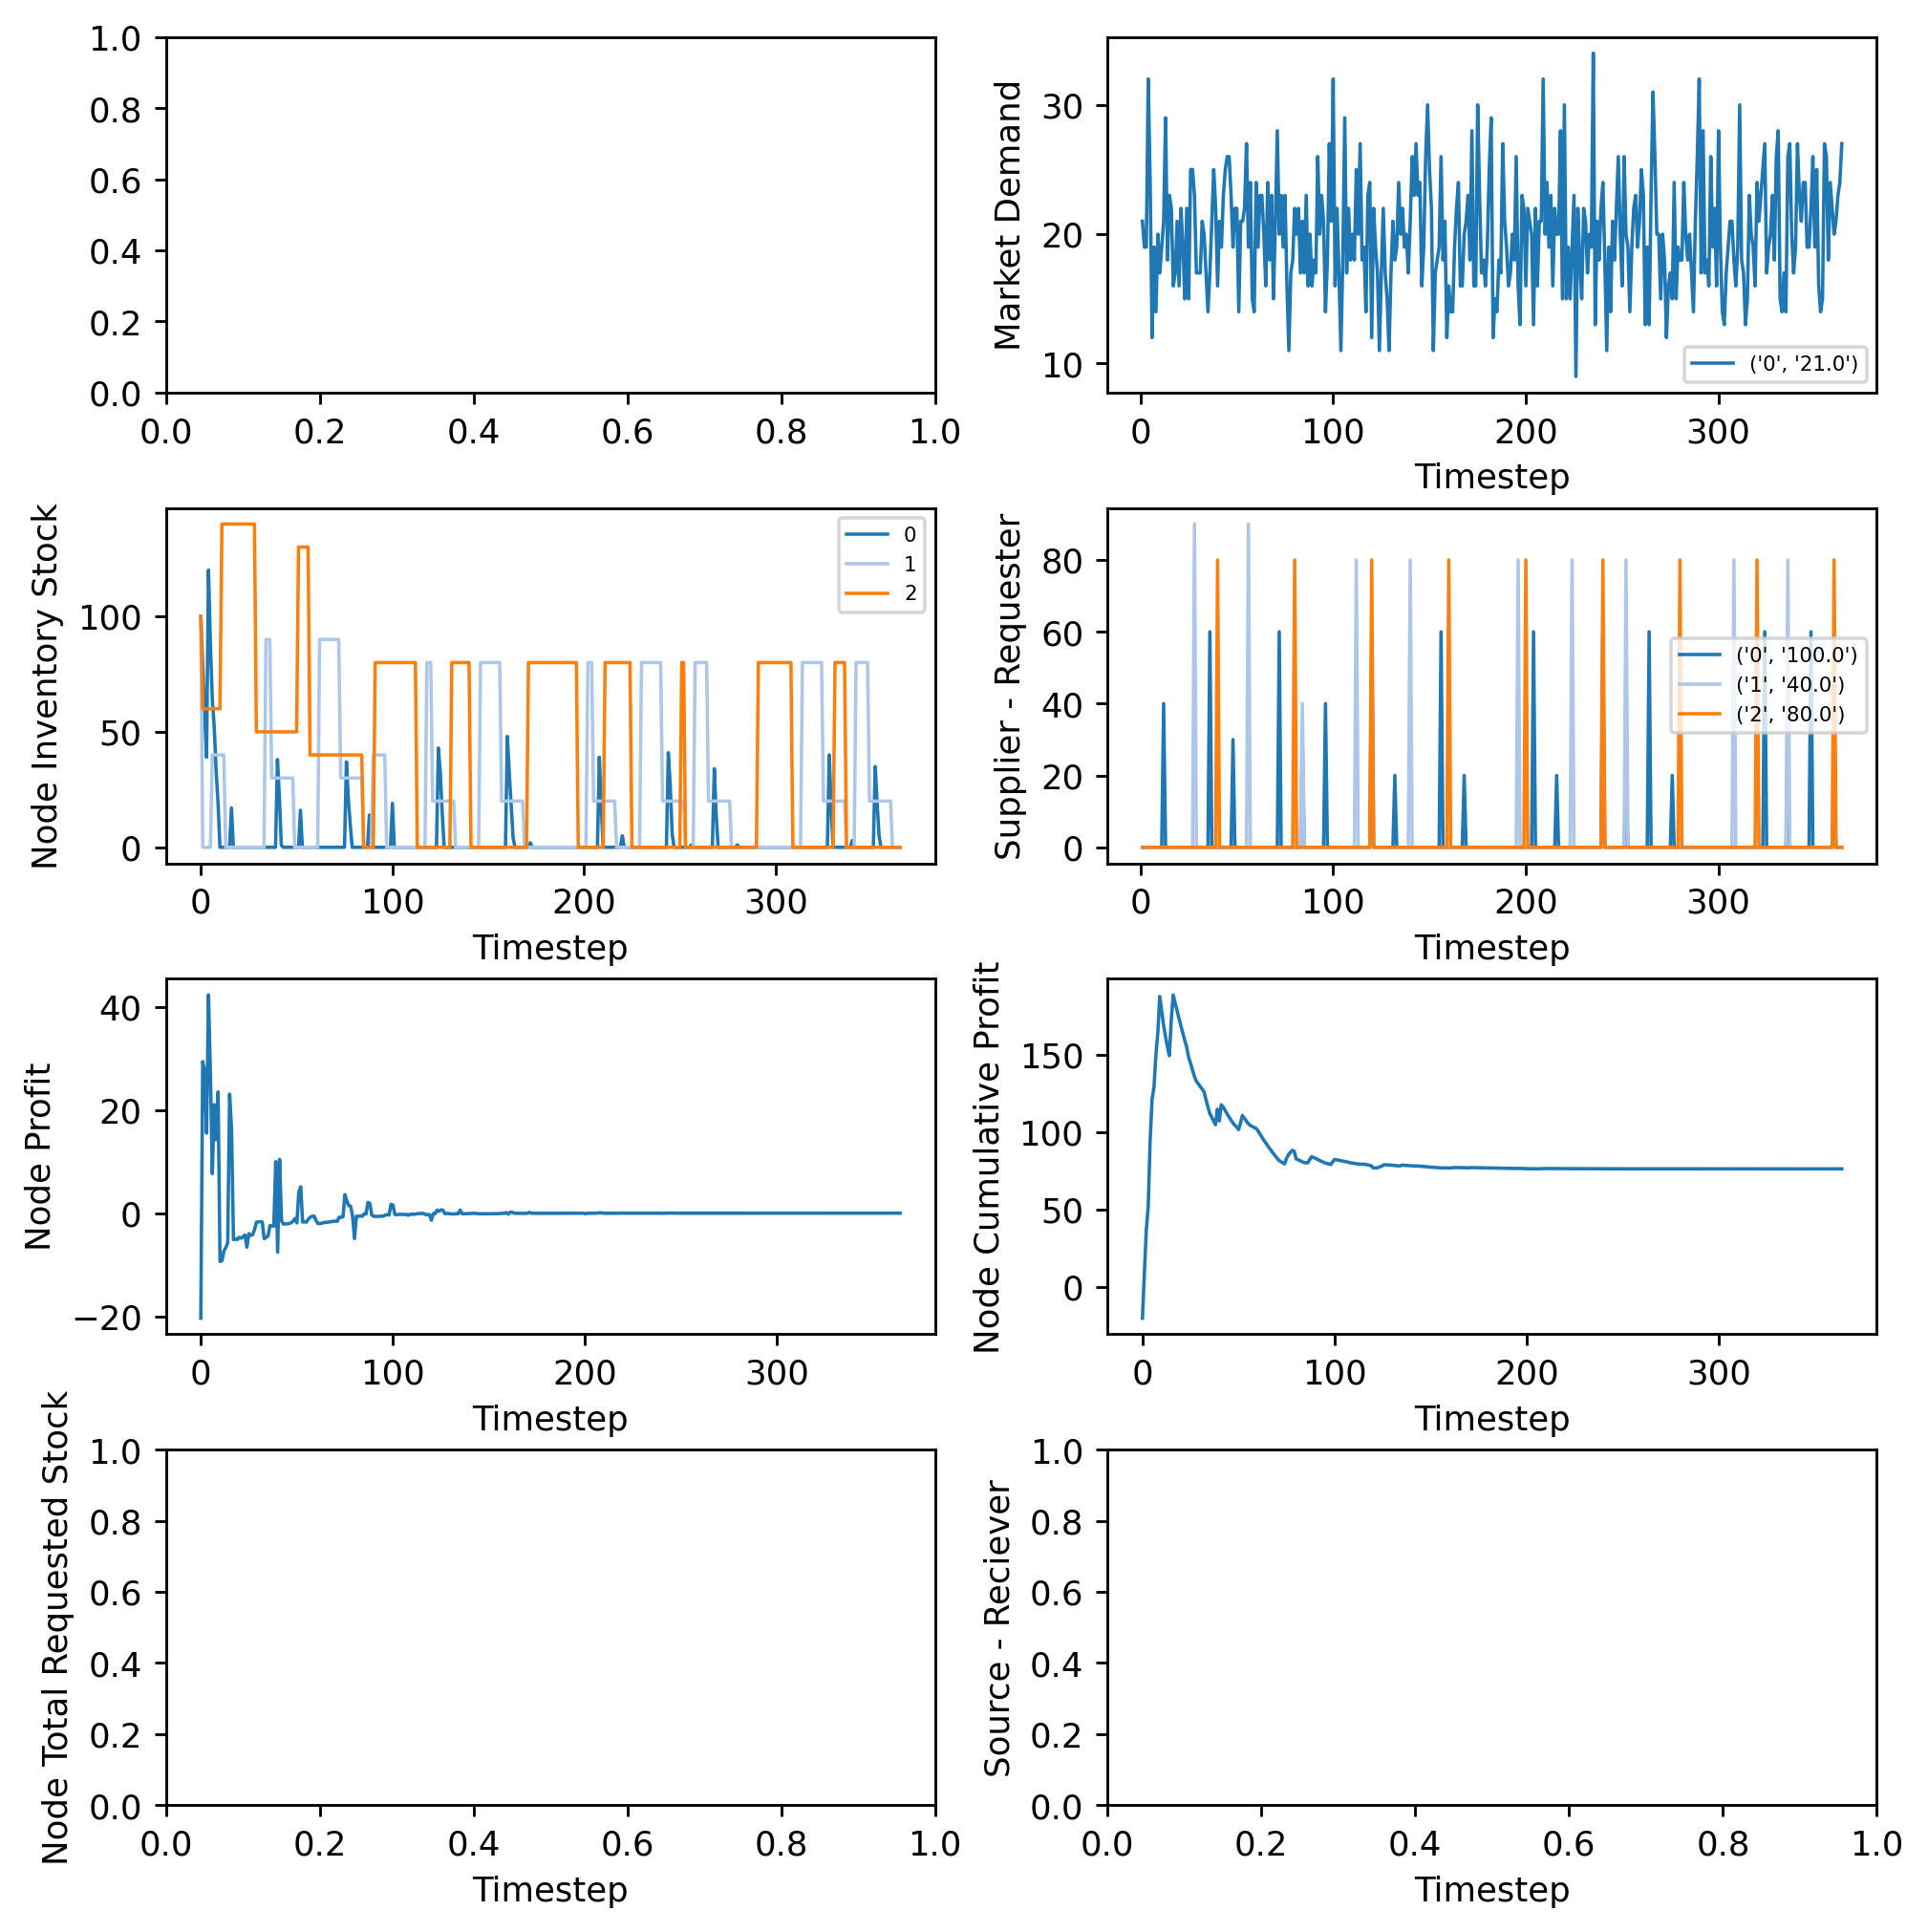

In [236]:
periods = 365

env = or_gym.make('InvManagement-v1', periods=periods)
env.I0 = np.array([100,100,100])
env.I[0] = env.I0
env.state[0:3] = env.I0
env.c = np.array([120,100,200])
filepath = 'conrenrepo/'

episodes = 1
raw_rewards = np.zeros((episodes, periods))
  
df_names = ['D', 'I', 'R', 'P', 'T'] # Initialising DataFrame names
# ['Market Demand', 'Inventory Node Stock', 'Reorder Amount', 'Node Profit', 'Edge Quantities'] Translated from above

for episode in range(episodes):
    for timestep in range(periods):
        #Check retailer
        actions = np.zeros(3)
        
        
        R_threshold = 60
        D_threshold = 140
        M_threshold = 480
        
        
        if env.period == 0:
            actions = np.array([100,100,100])
        
        if env.period % 12 == 0:
            if env.state[0] < R_threshold:
                actions[0] = R_threshold - env.state[0]
        
        if env.period % 28 == 0:
            if env.state[1] < D_threshold:
                actions[1] = D_threshold - env.state[1]
          
        if env.period % 40 == 0:        
                if env.state[2] < M_threshold:
                    actions[2] = M_threshold - env.state[2]
        
        obs, reward, _, _ = env.step(actions)
        raw_rewards[episode,timestep] = reward
        
        for df_name in df_names:
            df = getattr(env, df_name) # Get the DataFrame from the environment for the specific data
             
            if not os.path.exists(filepath + f'/{episode}/'): # If the directory does not exist, create it
                os.makedirs(filepath + f'/{episode}/')
                
            pd.DataFrame(df).to_csv(filepath + f'/{episode}/{df_name}.csv') # Save the DataFrame as a csv file
        
        
    #     action = actions[timestep]
    #     obs, reward, _, _ = env.step(action)
    #     print(env.I0)
    #     raw_rewards[episode,timestep] = reward
                
    #     for df_name in df_names:
    #         df = getattr(env, df_name) # Get the DataFrame from the environment for the specific data
                
    #         if not os.path.exists(filepath + f'/{episode}/'): # If the directory does not exist, create it
    #             os.makedirs(filepath + f'/{episode}/')
                
    #         pd.DataFrame(df).to_csv(filepath + f'/{episode}/{df_name}.csv') # Save the DataFrame as a csv file
                
    # # env = env.reset() # Reset the environment for the next episode
    # # env.seed_int = int(episode) # Select a new seed for the next episode
            

fig, ax = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(8, 8)


df_names = ['D', 'I', 'R', 'P', 'T']
df_headers = [[0,1], [0], [0,1], [0], [0,1]]
data = {}

for i, df_name in enumerate(df_names):
    df = pd.read_csv(filepath + f'/{episode}/{df_name}.csv', index_col=[0], header=df_headers[i])
    data[df_name] = df

cmap = plt.get_cmap('tab20')


for i, retailer_market in enumerate(data['D'].columns):
    retailer, market = retailer_market
    ax[0,1].plot(data['D'][retailer_market], linewidth=1.0, label=retailer_market)

for i, node_num in enumerate(data['I'].columns):
    ax[1,0].plot(data['I'][node_num], linewidth=1.0, label=node_num, color=cmap(i))

for i, supplier_requester in enumerate(data['R'].columns):
    supplier, requester = supplier_requester
    ax[1,1].plot(data['R'][supplier_requester], linewidth=1.0, label=supplier_requester, color=cmap(i))

for i, node_num in enumerate(data['P'].columns):
    ax[2,0].plot(data['P'][node_num], linewidth=1.0, label=node_num, color=cmap(i))
    ax[2,1].plot(np.cumsum(data['P'][node_num]), linewidth=1.0, label=node_num, color=cmap(i))

# Rtot = data['R'].groupby('Requester', axis=1).sum()

# for i, node_num in enumerate(Rtot.columns):
#     ax[3,0].plot(Rtot[node_num], linewidth=1.0, label=node_num, color=cmap(i))

# for i, source_reciever in enumerate(data['T'].columns):
#     source, reciever = source_reciever
#     ax[3,1].plot(data['T'][source_reciever], linewidth=1.0, label=source_reciever, color=cmap(i))

ax[0,1].legend(fontsize=6)
ax[1,0].legend(fontsize=6)
ax[1,1].legend(fontsize=6)

ax[0,1].set_xlabel('Timestep')
ax[0,1].set_ylabel('Market Demand')

ax[1,0].set_xlabel('Timestep')
ax[1,0].set_ylabel('Node Inventory Stock')

ax[1,1].set_xlabel('Timestep')
ax[1,1].set_ylabel('Supplier - Requester')

ax[2,0].set_xlabel('Timestep')
ax[2,0].set_ylabel('Node Profit')

ax[2,1].set_xlabel('Timestep')
ax[2,1].set_ylabel('Node Cumulative Profit')

ax[3,0].set_xlabel('Timestep')
ax[3,0].set_ylabel('Node Total Requested Stock')

ax[3,1].set_xlabel('Timestep')
ax[3,1].set_ylabel('Source - Reciever')


fig.tight_layout(h_pad=0.0, w_pad=0.0)

#     save_dir = f'./figures/{env_name}/'

save_dir = filepath

#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

fig.savefig(save_dir + 'episode.pdf')
fig.show()